In [92]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

# Get ZTF fit

In [93]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [94]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [95]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

fink_colors = ['#15284F', '#F5622E']

V_minus_g = -0.2833
V_minus_r = 0.1777

In [96]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [97]:
data['sHG1G2_dSpin'] = np.sqrt( (data['sHG1G2_err_alpha0']*np.cos(np.radians(data['sHG1G2_delta0'])))**2 + data['sHG1G2_err_delta0']**2 )


# # Remove solutions above 90 deg of latitude
cond = data.sHG1G2_delta0 > 90
data.loc[cond,'sHG1G2_delta0'] = 90
print(f'above 90: {len(data[cond])} ')

cond = data.sHG1G2_delta0 < -90
data.loc[cond,'sHG1G2_delta0'] = -90
print(f'below 90: {len(data[cond])} ')


above 90: 0 
below 90: 0 


In [98]:
bft = pd.read_parquet(bft_file)

In [99]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'proper_elements.proper_semi_major_axis.value',
        'proper_elements.proper_eccentricity.value',
        'proper_elements.proper_inclination.value',
        'proper_elements.proper_sine_inclination.value',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'colors.i-z.color.value', 'colors.i-z.color.error.min', 'colors.i-z.color.error.max',
        'colors.i-z.facility', 'colors.i-z.observer', 'colors.i-z.epoch',
        'colors.i-z.delta_time', 'colors.i-z.id_filter_1',
        'colors.i-z.id_filter_2', 'colors.i-z.phot_sys', 'colors.i-z.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value', 'spins.1.RA0.error.max', 'spins.1.DEC0.error.max',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value', 'spins.2.RA0.error.max', 'spins.2.DEC0.error.max',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value', 'spins.3.RA0.error.max', 'spins.3.DEC0.error.max',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value', 'spins.4.RA0.error.max', 'spins.4.DEC0.error.max',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]        

In [100]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [101]:
# data

In [11]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_sHG1G2_g = (data.sHG1G2_G1_g>thres)  & (data.sHG1G2_G2_g>thres) & ((1-data.sHG1G2_G1_g-data.sHG1G2_G2_g)>thres)
mask_sHG1G2_r = (data.sHG1G2_G1_r>thres)  & (data.sHG1G2_G2_r>thres) & ((1-data.sHG1G2_G1_r-data.sHG1G2_G2_r)>thres)
mask_sHG1G2_ZTF = mask_sHG1G2_g & mask_sHG1G2_r
mask_sHG1G2_fit = (data.sHG1G2_fit==0)  & (data.sHG1G2_status>=2)
mask_sHG1G2 = mask_sHG1G2_fit & mask_sHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.sHG1G2_alpha0>thres) & ( np.abs(360-data.sHG1G2_alpha0)>thres )  & \
           ( np.abs(data.sHG1G2_alpha0-180)>thres) & ( np.abs(data.sHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.minphase<2.5

# Global mask
maskFINK = mask_sHG1G2 & maskSpin #& maskPhase


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_sHG1G2_g]):6d}  ({100.*len(data[mask_sHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_sHG1G2_r]):6d}  ({100.*len(data[mask_sHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_sHG1G2]):6d}  ({100.*len(data[mask_sHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask FINK      : {len(data[maskFINK]):6d}  ({100.*len(data[maskFINK])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}   : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')

 All data       : 115147  (100.00%)

  Mask HG g      : 114904  ( 99.79%)
  Mask HG r      : 114906  ( 99.79%)
  Mask HG g+r    : 112564  ( 97.76%)

  Mask HG1G2 g   :  56815  ( 49.34%)
  Mask HG1G2 r   :  62043  ( 53.88%)
  Mask HG1G2 g+r :  40727  ( 35.37%)

  Mask SHG1G2 g  :  70735  ( 61.43%)
  Mask SHG1G2 r  :  75553  ( 65.61%)
  Mask SHG1G2 g+r:  55601  ( 48.29%)

  Mask Spin      : 111365  ( 96.72%)

  Mask FINK      :  54558  ( 47.38%)
  Mask phase 2   :  57515  ( 49.95%)
  Mask phase 3   :  79455  ( 69.00%)
  Mask phase 4   :  93564  ( 81.26%)
  Mask phase 5   : 101933  ( 88.52%)


# General description of the sample

In [12]:
data.loc[maskFINK, 'sso_class'].value_counts()

MB>Inner        18496
MB>Middle       17945
MB>Outer        15671
Phocaea           544
Trojan            513
Hungaria          426
Mars-Crosser      394
MB>Cybele         254
MB>Hilda          228
NEA>Apollo         40
NEA>Amor           40
NEA>Aten            5
Centaur             2
Name: sso_class, dtype: int64

Text(0, 0.5, 'Sine of inclination ($\\sin$i)')

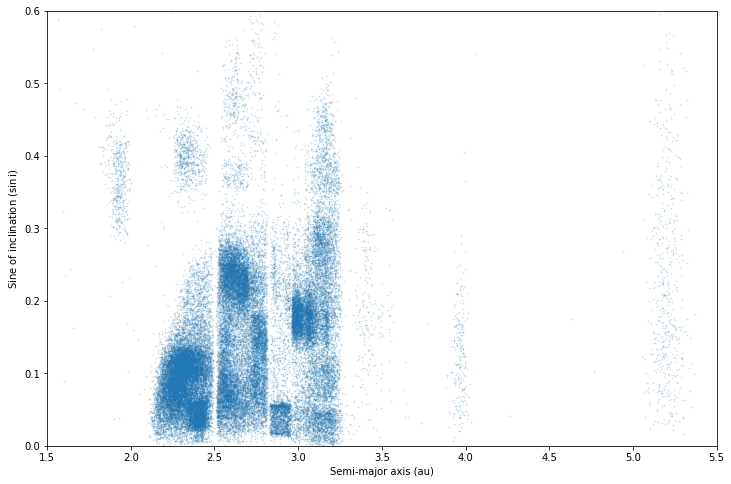

In [13]:
As = data.loc[maskFINK,'orbital_elements.semi_major_axis.value']
Es = data.loc[maskFINK,'orbital_elements.eccentricity.value']
Is = data.loc[maskFINK,'orbital_elements.inclination.value']

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(As, np.sin(np.radians(Is)), marker='.', alpha=0.2, s=2);


ax.set_xlim(1.5,5.5)
ax.set_ylim(0, 0.6)
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'Sine of inclination ($\sin$i)')

# fig.savefig(f'{data_fink}plots/types.png', facecolor='white', dpi=150)

# Spins!

In [14]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'sHG1G2_alpha0'
yax = 'sHG1G2_delta0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

In [15]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)

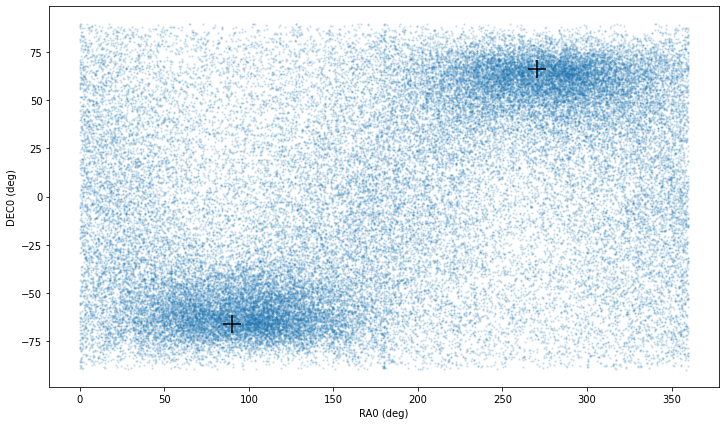

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'sHG1G2_alpha0'
yax = 'sHG1G2_delta0'

# Sample FINK
ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_selected.png'), facecolor='white')


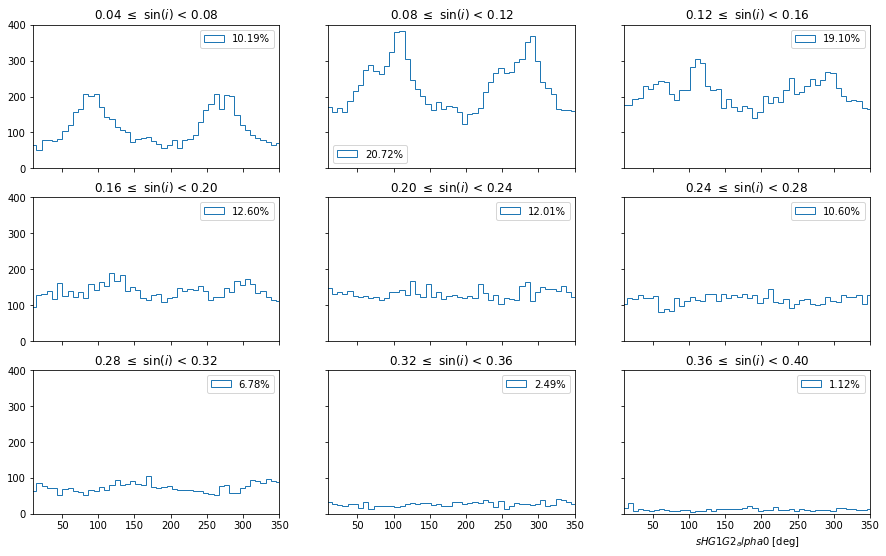

In [17]:
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))

fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)
m = maskFINK

step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):

        mi = (Is[m] >= count*step) * (Is[m] < (count+1)*step)
        ax[i, j].hist(
            data['sHG1G2_alpha0'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['sHG1G2_alpha0'][m][mi])/len(data['sHG1G2_alpha0'][m]) * 100)
        )

        count += 1
        ax[i, j].set_title(r'{:.2f} $\leq$ $\sin(i)$ < {:.2f}'.format(count*step, (count+1)*step))
        ax[i, j].set_xlim(10, 350)

        # only on the last one
        ax[i, j].legend(fontsize=10)
plt.xlabel(r'$sHG1G2_alpha0$ [deg]')
# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_distrib.png', facecolor='white', dpi=150)
plt.show()

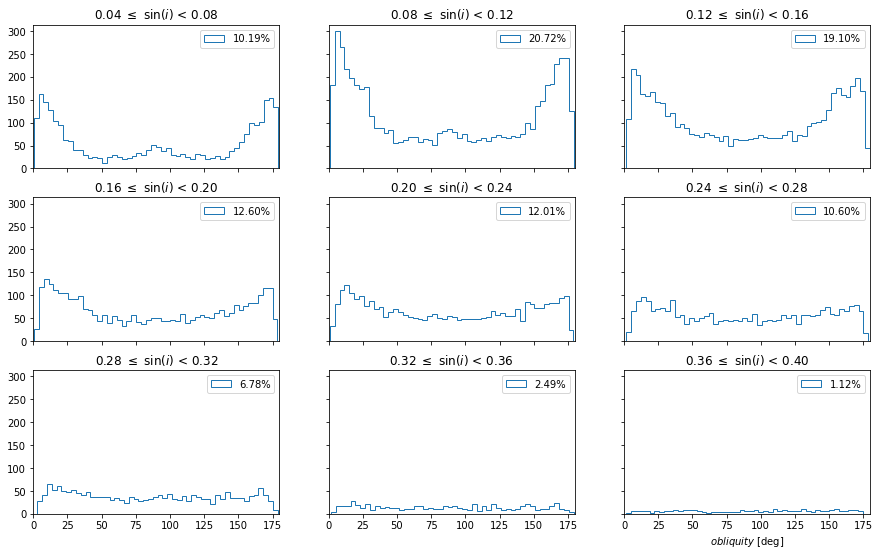

In [18]:
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))

fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)
m = maskFINK


step = 0.04
count = 0
for i in range(0, 3):
    for j in range(0, 3):

        mi = (Is[m] >= count*step) * (Is[m] < (count+1)*step)
        ax[i, j].hist(
            data['obliquity'][m][mi], 
            bins=50, 
            density=False,
            histtype='step', 
            label='{:.2f}%'.format(len(data['obliquity'][m][mi])/len(data['obliquity'][m]) * 100)
        )

        count += 1
        ax[i, j].set_title(r'{:.2f} $\leq$ $\sin(i)$ < {:.2f}'.format(count*step, (count+1)*step))
        ax[i, j].set_xlim(0,180)

        # only on the last one
        ax[i, j].legend(fontsize=10)
        
plt.xlabel(r'$obliquity$ [deg]')
# plt.yscale('log')
# fig.savefig(f'{data_fink}plots/obliquity_vs_incl_distrib_with_flip.png', facecolor='white', dpi=150)
plt.show()

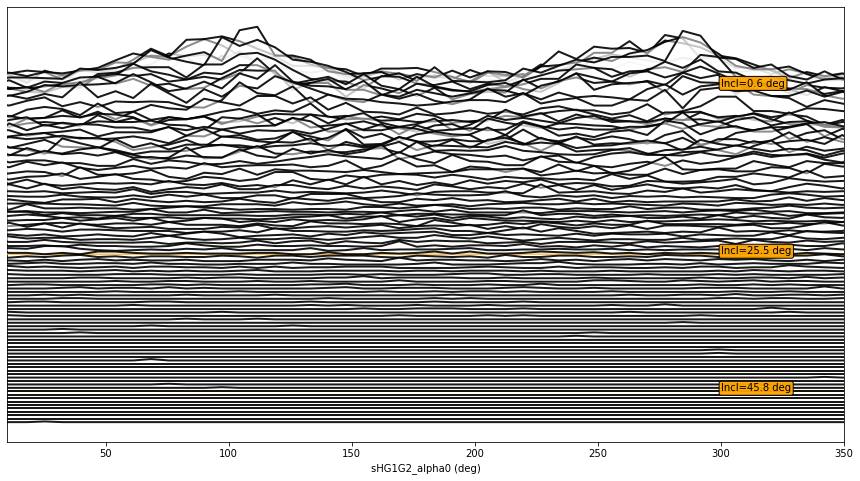

In [19]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

cond = maskFINK

d_1 = data.loc[cond,'sHG1G2_alpha0']
Is = np.sin(np.deg2rad(data['orbital_elements.inclination.value']))
d_2 = Is[cond]

H, x, y = np.histogram2d(d_1, d_2, bins=(50, 100))

nx = len(H)
ny = len(H[0])
fig = plt.figure(figsize=(15, 8), facecolor='w')
ax = fig.add_subplot(111)
maxs = []
for iy in range(ny):
    # Offset each line by this amount: we want the first lines plotted
    # at the top of the chart and to work our way down
    offset = (ny-iy)*5
    # Plot the line and fill under it: increase the z-order each time
    # so that lower lines and their fills are plotted over higher ones
#     yhat = savgol_filter(H.T[iy], 7, 3)
    yhat = H.T[iy]
    xcenters = (x[:-1] + x[1:]) / 2
    ax.plot(xcenters, yhat+offset, 'k', lw=2, zorder=(iy+1)*2, alpha=0.9)
    ax.fill_between(xcenters, yhat+offset, offset, facecolor='w', lw=0, zorder=(iy+1)*2-1, alpha=0.5)
    if np.max(yhat) > 1.1 * np.mean(yhat):
        max_ = np.argmax(yhat)
        maxs.append([xcenters[max_], yhat[max_]])
ax.get_yaxis().set_visible(False)

for incl in [10, int(ny/2), ny-1]:
    ax.text(300, offset*incl, 'Incl={:.1f} deg'.format(np.rad2deg(y[::-1][:-1][incl])), color='black', 
        bbox=dict(facecolor='orange', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.95), zorder=1e6)
    plt.axhline(offset*incl, color='orange', zorder=5)
plt.xlim(10, 350)
plt.xlabel('sHG1G2_alpha0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_incl_waterfall.png', facecolor='white', dpi=150)
plt.show()

# Phase parameters

In [20]:
data.loc[maskFINK,'taxonomy.complex'].value_counts()

S     14391
C      6160
X      3715
V      1975
B      1400
L      1267
U       936
D       928
K       732
A       550
Ch      213
Q       210
P       176
M       129
Z        20
T        16
E        12
R         9
O         3
Name: taxonomy.complex, dtype: int64

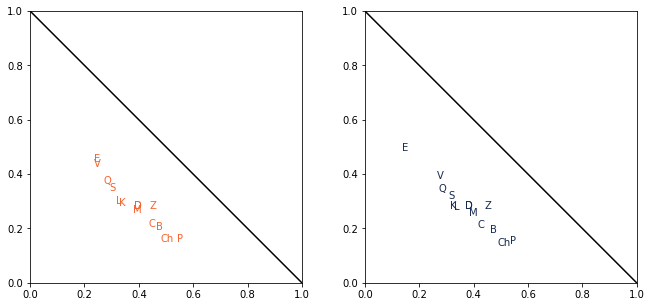

In [38]:
fig, ax = plt.subplots(1,2, figsize=(11, 5))

xx = np.linspace(0,1,num=10)

for a in ax:
    a.plot(xx, 1-xx, linestyle='solid', color='black')
    a.set_aspect('equal')
    a.set_xlim(0,1)
    a.set_ylim(0,1)

for c in ['E','V','Q','S','C','B','D','K','L','D','Ch','P','M','Z']:
    
    
    cond = maskFINK & (data['taxonomy.complex']==c)
    
    
    G1_m = data.loc[cond,'sHG1G2_G1_g'].mean()
    G1_s = data.loc[cond,'sHG1G2_G1_g'].std()
    G2_m = data.loc[cond,'sHG1G2_G2_g'].mean()
    G2_s = data.loc[cond,'sHG1G2_G2_g'].std()
    
    # print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')
    ax[1].text( G1_m, G2_m, c, ha='center', va='center', color=fink_colors[0] )

    
    
    G1_m = data.loc[cond,'sHG1G2_G1_r'].mean()
    G1_s = data.loc[cond,'sHG1G2_G1_r'].std()
    G2_m = data.loc[cond,'sHG1G2_G2_r'].mean()
    G2_s = data.loc[cond,'sHG1G2_G2_r'].std()
    
    # print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')
    ax[0].text( G1_m, G2_m, c, ha='center', va='center', color=fink_colors[1] )



E    0.25 0.22    0.46 0.21
V    0.25 0.15    0.44 0.10
Q    0.28 0.16    0.38 0.12
A    0.30 0.17    0.36 0.11
S    0.30 0.17    0.35 0.11
L    0.33 0.19    0.30 0.12
K    0.34 0.19    0.30 0.11
D    0.40 0.21    0.28 0.12
M    0.40 0.21    0.27 0.11
Z    0.45 0.22    0.28 0.14
C    0.45 0.23    0.22 0.13
B    0.48 0.23    0.21 0.13
Ch   0.50 0.21    0.16 0.09
P    0.55 0.23    0.16 0.10


Text(0.3484386446159602, 0.30652424307882736, 'All')

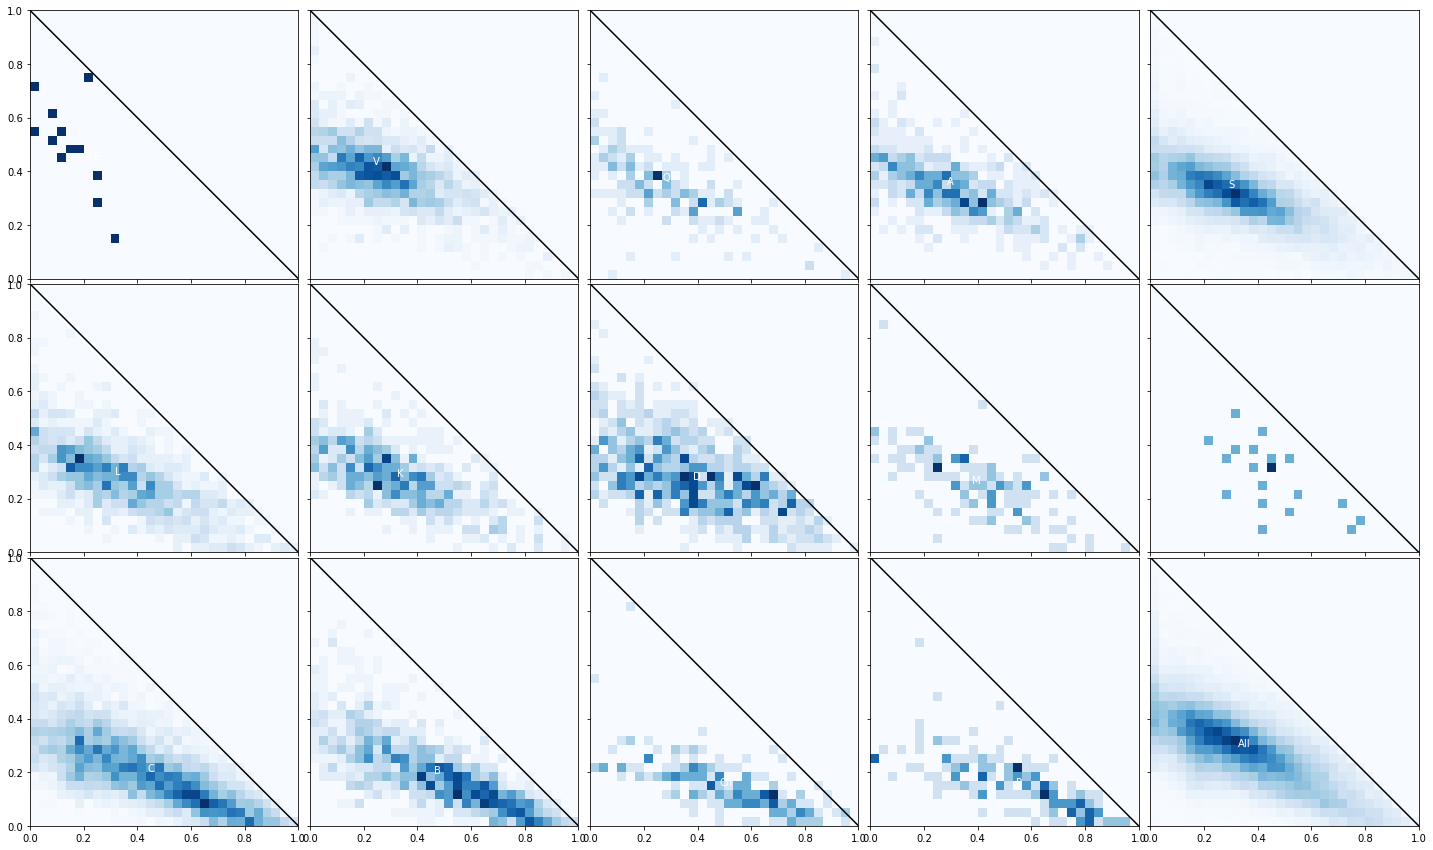

In [53]:
fig, ax = plt.subplots(3, 5, figsize=(25, 15), sharex=True, sharey=True, gridspec_kw={'wspace':0.02, 'hspace':0.02})
axs = ax.ravel()

xx = np.linspace(0,1,num=20)

for a in axs:
    a.plot(xx, 1-xx, linestyle='solid', color='black')
    a.set_aspect('equal')
    a.set_xlim(0,1)
    a.set_ylim(0,1)

r = [ [0,1],[0,1] ]
b = 30
for i,c in enumerate(['E','V','Q','A','S',
                      'L','K','D','M','Z',
                      'C','B','Ch','P']):
    
    
    cond = maskFINK & (data['taxonomy.complex']==c)
    
    G1_m = data.loc[cond,'sHG1G2_G1_r'].mean()
    G1_s = data.loc[cond,'sHG1G2_G1_r'].std()
    G2_m = data.loc[cond,'sHG1G2_G2_r'].mean()
    G2_s = data.loc[cond,'sHG1G2_G2_r'].std()
    
    print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')

    axs[i].hist2d( data.loc[cond,'sHG1G2_G1_g'], data.loc[cond,'sHG1G2_G2_g'], range=r, bins=b, cmap='Blues' )
    axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )

i = i+1
G1_m = data.loc[maskFINK,'sHG1G2_G1_r'].mean()
G1_s = data.loc[maskFINK,'sHG1G2_G1_r'].std()
G2_m = data.loc[maskFINK,'sHG1G2_G2_r'].mean()
G2_s = data.loc[maskFINK,'sHG1G2_G2_r'].std()
axs[i].hist2d( data.loc[maskFINK,'sHG1G2_G1_g'], data.loc[maskFINK,'sHG1G2_G2_g'], range=r, bins=b, cmap='Blues' )
axs[i].text( G1_m, G2_m, 'All', ha='center', va='center', color='white' )


E    0.25 0.22    0.46 0.21
V    0.25 0.15    0.44 0.10
Q    0.28 0.16    0.38 0.12
A    0.30 0.17    0.36 0.11
S    0.30 0.17    0.35 0.11
L    0.33 0.19    0.30 0.12
K    0.34 0.19    0.30 0.11
D    0.40 0.21    0.28 0.12
M    0.40 0.21    0.27 0.11
Z    0.45 0.22    0.28 0.14
C    0.45 0.23    0.22 0.13
B    0.48 0.23    0.21 0.13
Ch   0.50 0.21    0.16 0.09
P    0.55 0.23    0.16 0.10


Text(0.3506183664597748, 0.28766300057781913, 'All')

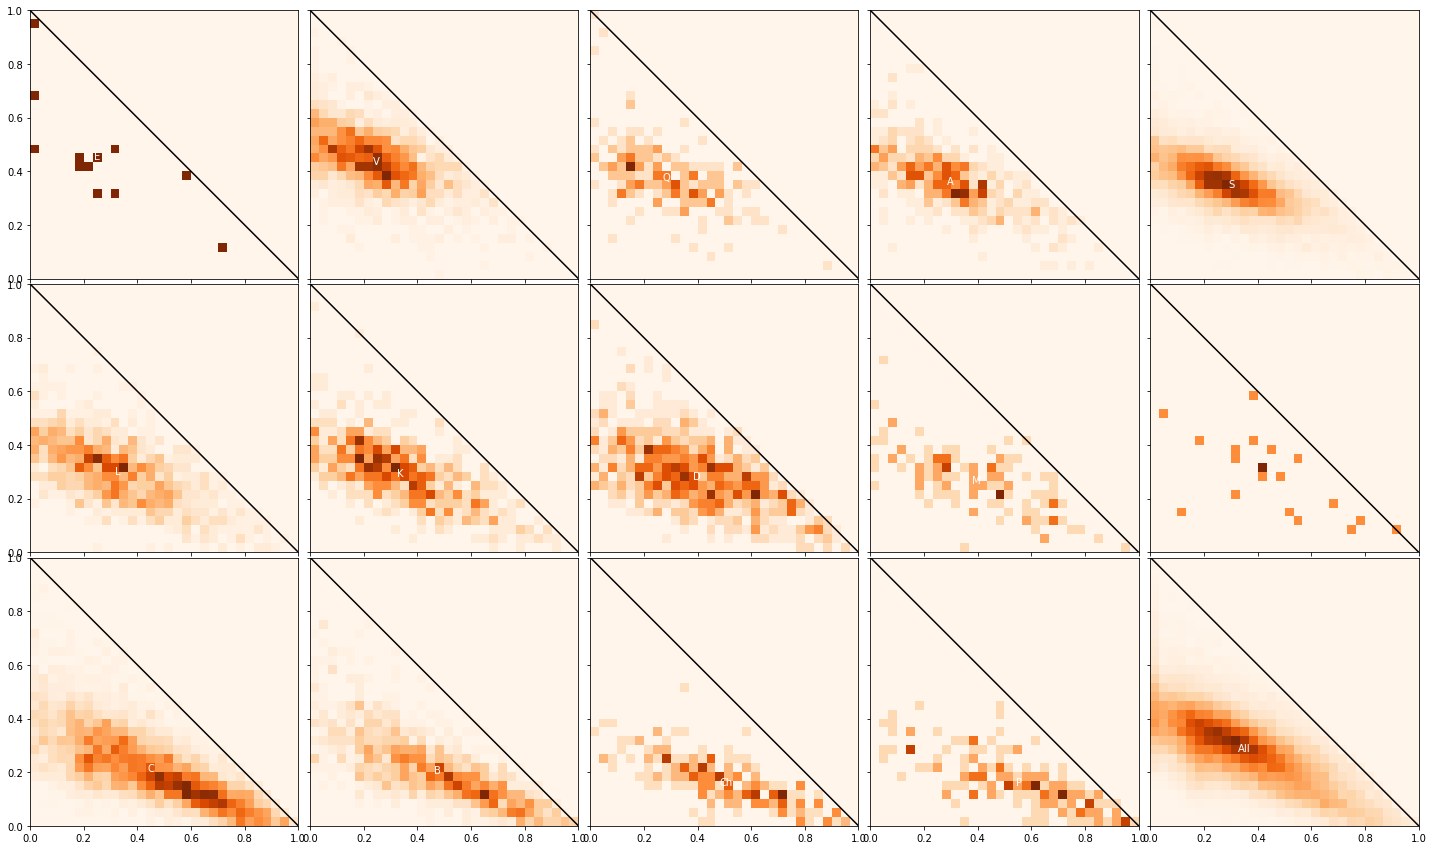

In [52]:
fig, ax = plt.subplots(3, 5, figsize=(25, 15), sharex=True, sharey=True, gridspec_kw={'wspace':0.02, 'hspace':0.02})
axs = ax.ravel()

xx = np.linspace(0,1,num=40)

for a in axs:
    a.plot(xx, 1-xx, linestyle='solid', color='black')
    a.set_aspect('equal')
    a.set_xlim(0,1)
    a.set_ylim(0,1)

r = [ [0,1],[0,1] ]
b = 30
for i,c in enumerate(['E','V','Q','A','S',
                      'L','K','D','M','Z',
                      'C','B','Ch','P']):
    
    
    cond = maskFINK & (data['taxonomy.complex']==c)
    
    G1_m = data.loc[cond,'sHG1G2_G1_r'].mean()
    G1_s = data.loc[cond,'sHG1G2_G1_r'].std()
    G2_m = data.loc[cond,'sHG1G2_G2_r'].mean()
    G2_s = data.loc[cond,'sHG1G2_G2_r'].std()
    
    print(f'{c:2s}   {G1_m:4.2f} {G1_s:4.2f}    {G2_m:4.2f} {G2_s:4.2f}')

    axs[i].hist2d( data.loc[cond,'sHG1G2_G1_r'], data.loc[cond,'sHG1G2_G2_r'], range=r, bins=b, cmap='Oranges' )
    axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )


i = i+1
G1_m = data.loc[maskFINK,'sHG1G2_G1_g'].mean()
G1_s = data.loc[maskFINK,'sHG1G2_G1_g'].std()
G2_m = data.loc[maskFINK,'sHG1G2_G2_g'].mean()
G2_s = data.loc[maskFINK,'sHG1G2_G2_g'].std()
axs[i].hist2d( data.loc[maskFINK,'sHG1G2_G1_g'], data.loc[maskFINK,'sHG1G2_G2_g'], range=r, bins=b, cmap='Oranges' )
axs[i].text( G1_m, G2_m, 'All', ha='center', va='center', color='white' )


In [70]:
print('Difference of G1 G2 in g/r filters')

for i,c in enumerate(['E','V','Q','A','S',
                      'L','K','D','M','Z',
                      'C','B','Ch','P']):
    
    
    cond = maskFINK & (data['taxonomy.complex']==c)
    
    G1_m_g = data.loc[cond,'sHG1G2_G1_g'].mean()
    G1_s_g = data.loc[cond,'sHG1G2_G1_g'].std()
    G2_m_g = data.loc[cond,'sHG1G2_G2_g'].mean()
    G2_s_g = data.loc[cond,'sHG1G2_G2_g'].std()
    
    G1_m_r = data.loc[cond,'sHG1G2_G1_r'].mean()
    G1_s_r = data.loc[cond,'sHG1G2_G1_r'].std()
    G2_m_r = data.loc[cond,'sHG1G2_G2_r'].mean()
    G2_s_r = data.loc[cond,'sHG1G2_G2_r'].std()
    
    print(f'{c:2s}   {G1_m_g-G1_m_r:5.2f}   {G2_m_g-G2_m_r:5.2f} ')


Difference of G1 G2 in g/r filters
E    -0.10    0.04 
V     0.03   -0.05 
Q     0.00   -0.03 
A     0.01   -0.03 
S     0.01   -0.03 
L     0.01   -0.02 
K    -0.01   -0.01 
D    -0.01   -0.00 
M     0.00   -0.01 
Z     0.00   -0.00 
C    -0.02   -0.00 
B    -0.00   -0.01 
Ch    0.01   -0.02 
P    -0.01   -0.01 


# Color

E    0.51 0.25
V    0.63 0.20
Q    0.57 0.22
A    0.64 0.22
S    0.61 0.21
L    0.62 0.21
K    0.57 0.22
D    0.58 0.22
M    0.54 0.22
Z    0.57 0.19
C    0.44 0.22
B    0.43 0.21
Ch   0.43 0.23
P    0.47 0.19


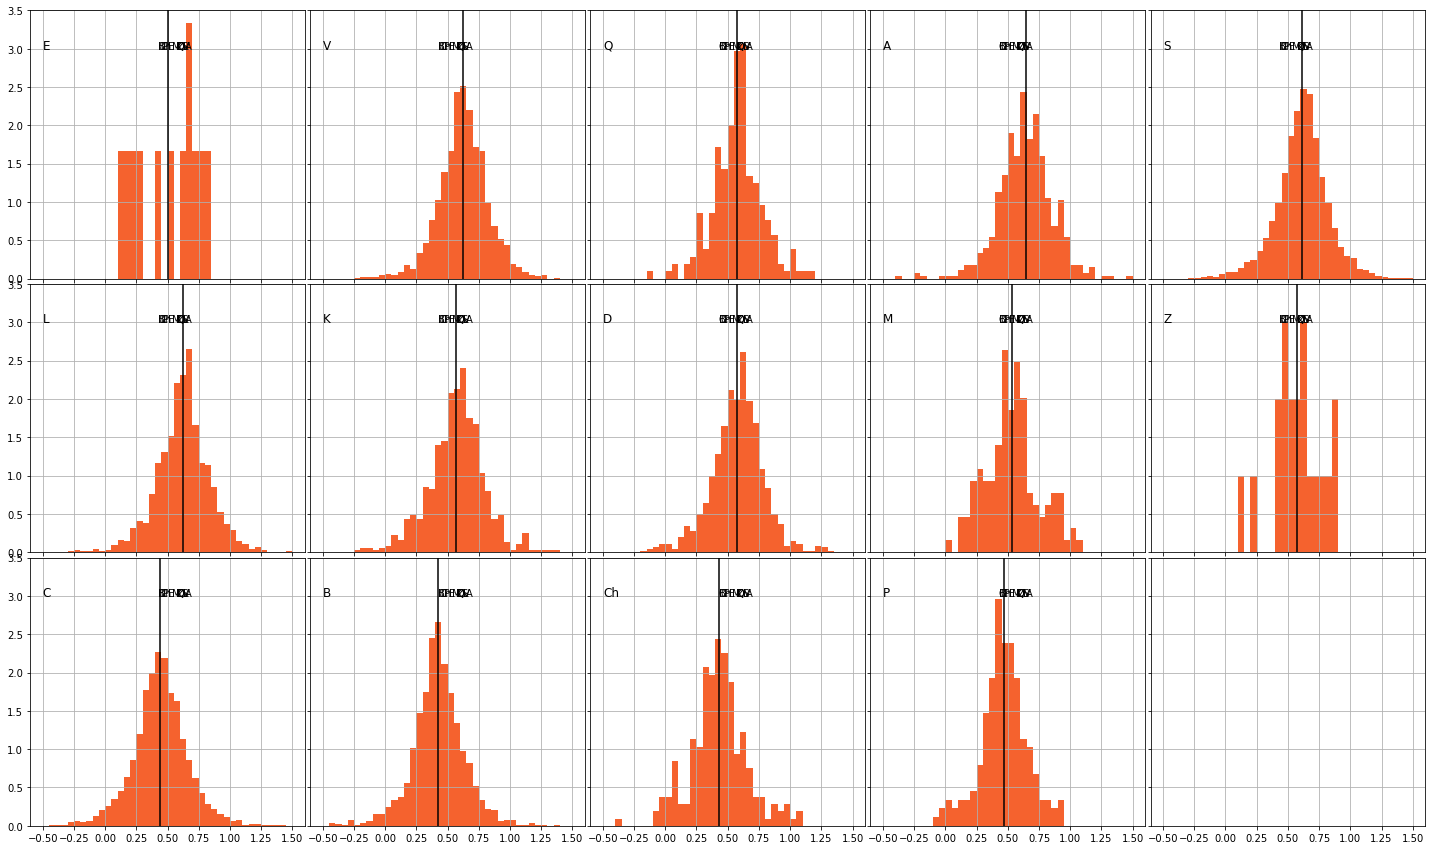

In [77]:
fig, ax = plt.subplots(3, 5, figsize=(25, 15), sharex=True, sharey=True, gridspec_kw={'wspace':0.02, 'hspace':0.02})
axs = ax.ravel()

xx = np.linspace(0,1,num=40)

for a in axs:
    a.grid()
    # a.set_aspect('equal')
    # a.set_xlim(0,1)
    # a.set_ylim(0,1)

r = [-0.5,1.5]
b = 40
complexes = ['E','V','Q','A','S',
                      'L','K','D','M','Z',
                      'C','B','Ch','P']
for i,c in enumerate(complexes):
    
    
    cond = maskFINK & (data['taxonomy.complex']==c)
    
    x = data.loc[cond,'sHG1G2_H_g']-data.loc[cond,'sHG1G2_H_r']
    gr_m = x.mean()
    gr_s = x.std()
    print(f'{c:2s}   {gr_m:4.2f} {gr_s:4.2f}')

    axs[i].hist( x, range=r, bins=b, color=fink_colors[1], density=True )
    # axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )

    axs[i].axvline( gr_m, color='black' )
    axs[i].text( -0.5, 3, c, fontsize='large' )
    
    for k in range(len(complexes)):
        axs[k].text( gr_m, 3, c)


InvalidIndexError: (0         False
1         False
2         False
3         False
4         False
          ...  
115142    False
115143    False
115144    False
115145    False
115146    False
Length: 115147, dtype: bool, 'sHG1G2_err_H_1')

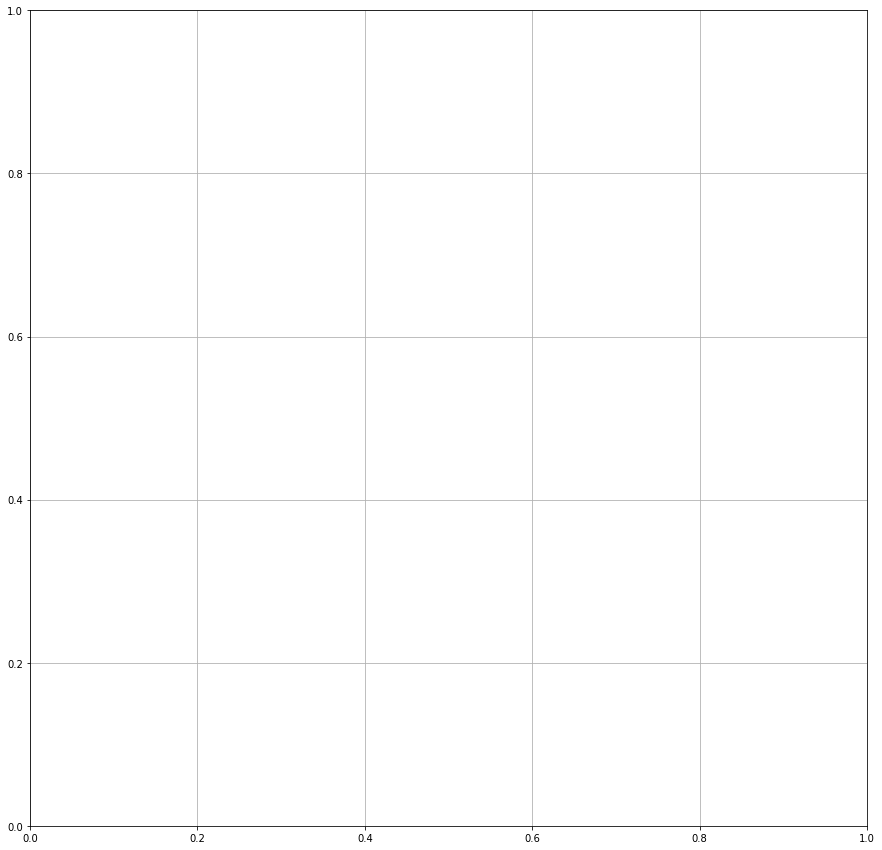

In [110]:
fig, ax = plt.subplots(figsize=(15, 15), sharex=True, sharey=True, gridspec_kw={'wspace':0.02, 'hspace':0.02})


ax.grid()
  
complexes = ['E','V','Q','A','S',
                      'L','K','D','M','Z',
                      'C','B','Ch','P']
complexes = ['V','Q','A','S',
                      'D','Z',
                      'C','B']
for i,c in enumerate(complexes):
    
    
    cond = maskFINK & (data['taxonomy.complex']==c) & \
           ( (data[cond,'sHG1G2_err_H_1']+data['sHG1G2_err_H_2']) <0.2) & \
           (data['colors.i-z.facility']=='SDSS') & (data['colors.i-z.color.value'].notna())
    x = data.loc[cond,'sHG1G2_H_g']-data.loc[cond,'sHG1G2_H_r']
    y = data.loc[cond,'colors.i-z.color.value']
    

    ax.scatter( x, y, label=c )
    # axs[i].text( G1_m, G2_m, c, ha='center', va='center', color='white' )

ax.legend()
ax.set_xlabel('Hg-Hr / ZTF')
ax.set_ylabel('i-z / SDSS')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.7, 0.5)

In [107]:

data.columns[:80]

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG_status', 'HG_fit',
       'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g', 'HG1G2_G2_g',
       'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r', 'HG1G2_G1_r',
       'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r', 'HG1G2_rms',
       'HG1G2_chi2red', 'HG1G2_status', 'HG1G2_fit', 'sHG1G2_max_phase_1',
       'sHG1G2_kurtosis_delta_RA_cos_DEC', 'sHG1G2_max_phase_2',
       'sHG1G2_max_cos_lambda', 'sHG1G2_fit', 'sHG1G2_R',
       'sHG1G2_min_cos_lambda', 'sHG1G2_kurtosis_delta_DEC', 'sHG1G2_n_obs',
       'sHG1G2_skew_delta_DEC', 'sHG1G2_err_G2_1', 'sHG1G2_err_G1_2',
       'sHG1G2_skew_delta_RA_cos_DEC', 'sHG1G2_n_days', 'sHG1G2_err_G1_1',
       'sHG1G2_rms', 'sHG1G2_err_G2_2', 'sHG1G2_G2_g',

In [81]:
data.loc[maskFINK,'colors.g-r.facility'].value_counts()

SMSS       23166
SDSS       14301
ZTF          105
PdM/T1M        1
Name: colors.g-r.facility, dtype: int64